# 对比多个模型结果

In [1]:
%config Completer.use_jedi = False

## 引入依赖包

In [14]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [4]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


## DataSet

### 数据集定义

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


## 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 181: 


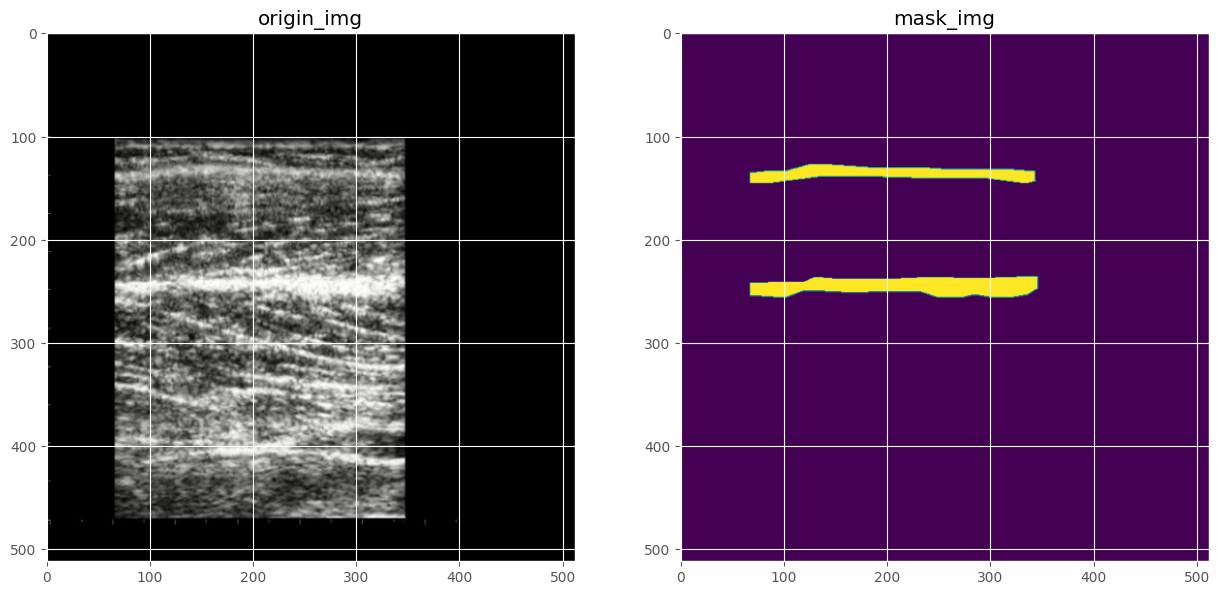

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## 多种网络模型

### UNet

In [9]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        return self.outc(x)


### UNext

In [21]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt


import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb


class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=512, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, embed_dims=[128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.n_classes = num_classes
        self.n_channels = input_channels
        
        self.encoder1 = nn.Conv2d(input_channels, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


## 模型测试

In [17]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 模型训练

In [18]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          project = 'U-Net',
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
#                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
    
    global_step = 0
    

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            


## train UNet

In [12]:
model = UNet(n_channels=3, n_classes=1, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)

train(model, device, project='U-Net')


Let's use 2 GPUs!


wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


Epoch 1/60:  20%|█▉        | 90/456 [00:30<01:01,  5.98img/s, loss (batch)=0.879]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.55batch/s]


Validation dice loss: 3.0620455741882324, IoU Score 0.22253689169883728


Epoch 1/60:  39%|███▉      | 180/456 [01:01<00:51,  5.41img/s, loss (batch)=0.89] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 2.6955673694610596, IoU Score 0.24555641412734985


Epoch 1/60:  59%|█████▉    | 270/456 [01:32<00:38,  4.81img/s, loss (batch)=0.725]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.48batch/s]


Validation dice loss: 2.354344606399536, IoU Score 0.3386768400669098


Epoch 1/60:  79%|███████▉  | 360/456 [02:04<00:17,  5.39img/s, loss (batch)=0.825]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 2.1870429515838623, IoU Score 0.4378187358379364


Epoch 1/60:  99%|█████████▊| 450/456 [02:36<00:01,  5.34img/s, loss (batch)=0.759]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 2.2301626205444336, IoU Score 0.35416504740715027


Epoch 2/60:  18%|█▊        | 84/456 [00:15<01:10,  5.27img/s, loss (batch)=0.693]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 2.005113124847412, IoU Score 0.45454132556915283


Epoch 2/60:  38%|███▊      | 174/456 [00:46<00:57,  4.94img/s, loss (batch)=0.887]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.9877245426177979, IoU Score 0.4775392711162567


Epoch 2/60:  58%|█████▊    | 264/456 [01:17<00:37,  5.08img/s, loss (batch)=0.762]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.9597843885421753, IoU Score 0.49219179153442383


Epoch 2/60:  78%|███████▊  | 354/456 [01:49<00:20,  4.90img/s, loss (batch)=0.789]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 1.9270968437194824, IoU Score 0.5083218216896057


Epoch 2/60:  97%|█████████▋| 444/456 [02:20<00:02,  5.07img/s, loss (batch)=0.77] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.8304462432861328, IoU Score 0.5068111419677734


Epoch 3/60:  17%|█▋        | 78/456 [00:14<01:13,  5.15img/s, loss (batch)=0.772]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 1.852392315864563, IoU Score 0.4887160360813141


Epoch 3/60:  37%|███▋      | 168/456 [00:46<00:57,  5.05img/s, loss (batch)=0.795]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 1.8298070430755615, IoU Score 0.5439950823783875


Epoch 3/60:  57%|█████▋    | 258/456 [01:17<00:39,  5.04img/s, loss (batch)=0.788]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.821534276008606, IoU Score 0.5010539889335632


Epoch 3/60:  76%|███████▋  | 348/456 [01:49<00:21,  4.95img/s, loss (batch)=0.798]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.7758028507232666, IoU Score 0.535378634929657


Epoch 3/60:  96%|█████████▌| 438/456 [02:21<00:03,  5.11img/s, loss (batch)=0.839]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 1.7176618576049805, IoU Score 0.5322959423065186


Epoch 4/60:  16%|█▌        | 72/456 [00:13<01:13,  5.20img/s, loss (batch)=0.754]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 1.7417805194854736, IoU Score 0.5215948820114136


Epoch 4/60:  36%|███▌      | 162/456 [00:44<00:56,  5.20img/s, loss (batch)=0.795]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.6976579427719116, IoU Score 0.5398148894309998


Epoch 4/60:  55%|█████▌    | 252/456 [01:16<00:38,  5.36img/s, loss (batch)=0.789]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.55batch/s]


Validation dice loss: 1.712816596031189, IoU Score 0.5536513924598694


Epoch 4/60:  75%|███████▌  | 342/456 [01:48<00:21,  5.21img/s, loss (batch)=0.904]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 1.65472412109375, IoU Score 0.5441088676452637


Epoch 4/60:  95%|█████████▍| 432/456 [02:20<00:04,  4.97img/s, loss (batch)=0.746]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 1.640642523765564, IoU Score 0.5475927591323853


Epoch 5/60:  14%|█▍        | 66/456 [00:12<01:18,  4.95img/s, loss (batch)=0.701]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.52batch/s]


Validation dice loss: 1.6120067834854126, IoU Score 0.5593070387840271


Epoch 5/60:  24%|██▎       | 108/456 [00:35<01:54,  3.04img/s, loss (batch)=0.807]


KeyboardInterrupt: 

## train UNext

In [22]:
model = UNext(input_channels=3, num_classes=1, img_size=512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)

train(model, device, project='U-Next')


Let's use 2 GPUs!


epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██
learning rate,▁█▇▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train iou,▁▄▃▂▃▃▂▄▄▆▃▆▅▅▄▄▄▃▃▆▆▇▄▅▆▅▆▇▇▃▆█▄▅▇▇▇▅▆▆
train loss,█▇▇▇▆▇▇▆▅▃▅▅▅▄▆▆▅▆▇▅▄▂▆▄▃▅▄▃▁▅▄▃▆▅▁▁▂▅▄▁
validation Dice,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
validation IoU Score,▁▁▃▅▄▆▆▇▇▇▇█▇█▇▇█████
epoch,5
learning rate,2e-05
step,966
train iou,0.40193


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.92batch/s]tch)=0.964]


Validation dice loss: 3.470149040222168, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.34batch/s]atch)=0.941]


Validation dice loss: 3.435772180557251, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.91batch/s]atch)=0.944]


Validation dice loss: 3.336682081222534, IoU Score 2.244509778392967e-05


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.77batch/s]atch)=0.929]


Validation dice loss: 3.2614691257476807, IoU Score 0.0007460407796315849


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.26batch/s]atch)=0.894]


Validation dice loss: 3.188491106033325, IoU Score 0.057310186326503754


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.94batch/s]tch)=0.873]


Validation dice loss: 3.115278482437134, IoU Score 0.3029128909111023


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.55batch/s]atch)=0.865]


Validation dice loss: 3.077920436859131, IoU Score 0.4685750901699066


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.94batch/s]atch)=0.909]


Validation dice loss: 3.026927947998047, IoU Score 0.5119298100471497


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.37batch/s]atch)=0.921]


Validation dice loss: 2.999772787094116, IoU Score 0.5074077248573303


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.34batch/s]atch)=0.876]


Validation dice loss: 2.845235824584961, IoU Score 0.44664421677589417


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.59batch/s]tch)=0.819]


Validation dice loss: 2.679764747619629, IoU Score 0.3523392975330353


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.05batch/s]atch)=0.9]  


Validation dice loss: 2.3760344982147217, IoU Score 0.39012131094932556


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.59batch/s]atch)=0.791]


Validation dice loss: 2.1577329635620117, IoU Score 0.4570361375808716


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.55batch/s]atch)=0.854]


Validation dice loss: 1.8611233234405518, IoU Score 0.5022948980331421


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.39batch/s]atch)=0.815]


Validation dice loss: 1.5627812147140503, IoU Score 0.5378900170326233


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.78batch/s]tch)=0.619]


Validation dice loss: 1.4349617958068848, IoU Score 0.5707272887229919


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.09batch/s]atch)=0.643]


Validation dice loss: 1.3666728734970093, IoU Score 0.5629226565361023


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.27batch/s]atch)=0.671]


Validation dice loss: 1.2631458044052124, IoU Score 0.5710563063621521


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.06batch/s]atch)=0.502]


Validation dice loss: 1.1721551418304443, IoU Score 0.5803173184394836


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.30batch/s]atch)=0.453]


Validation dice loss: 1.14075767993927, IoU Score 0.5957090258598328


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.71batch/s]tch)=0.496]


Validation dice loss: 1.1074774265289307, IoU Score 0.5941624641418457


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.29batch/s]atch)=0.535]


Validation dice loss: 1.062145709991455, IoU Score 0.5937747955322266


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.30batch/s]atch)=0.572]


Validation dice loss: 1.0879454612731934, IoU Score 0.5779716968536377


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.71batch/s]atch)=0.402]


Validation dice loss: 0.982496976852417, IoU Score 0.6016508936882019


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.54batch/s]atch)=0.375]


Validation dice loss: 0.9813589453697205, IoU Score 0.5285883545875549


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.22batch/s]tch)=0.382]


Validation dice loss: 0.8237659335136414, IoU Score 0.5909280180931091


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.86batch/s]atch)=0.479]


Validation dice loss: 0.7038378119468689, IoU Score 0.6046844720840454


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.15batch/s]atch)=0.258]


Validation dice loss: 0.8094577789306641, IoU Score 0.5240050554275513


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.75batch/s]atch)=0.29] 


Validation dice loss: 0.6475588083267212, IoU Score 0.602191150188446


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.71batch/s]atch)=0.261]


Validation dice loss: 0.6222831010818481, IoU Score 0.6107264757156372


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.23batch/s]tch)=0.326]


Validation dice loss: 0.6961930394172668, IoU Score 0.547893762588501


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.60batch/s]atch)=0.202]


Validation dice loss: 0.675972044467926, IoU Score 0.568223237991333


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.89batch/s]atch)=0.219]


Validation dice loss: 0.5407282710075378, IoU Score 0.6231769323348999


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.81batch/s]atch)=0.257]


Validation dice loss: 0.5192088484764099, IoU Score 0.6250026226043701


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.45batch/s]atch)=0.248]


Validation dice loss: 0.5045006275177002, IoU Score 0.6273335218429565


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.81batch/s]tch)=0.157]


Validation dice loss: 0.5408398509025574, IoU Score 0.6218568086624146


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.88batch/s]atch)=0.172]


Validation dice loss: 0.500087320804596, IoU Score 0.6272321939468384


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.58batch/s]atch)=0.24] 


Validation dice loss: 0.5159260630607605, IoU Score 0.6126980781555176


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.45batch/s]atch)=0.4]  


Validation dice loss: 0.6100193858146667, IoU Score 0.5674153566360474


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.38batch/s]atch)=0.321]


Validation dice loss: 0.5181669592857361, IoU Score 0.6149017214775085


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.34batch/s]tch)=0.113]


Validation dice loss: 0.4781627953052521, IoU Score 0.6393367052078247


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.58batch/s]atch)=0.192]


Validation dice loss: 0.48212364315986633, IoU Score 0.6346660852432251


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.36batch/s]atch)=0.157]


Validation dice loss: 0.5558321475982666, IoU Score 0.5994516015052795


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.80batch/s]atch)=0.566]


Validation dice loss: 0.47385066747665405, IoU Score 0.6441413760185242


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.12batch/s]atch)=0.188]


Validation dice loss: 0.5167766213417053, IoU Score 0.6065043210983276


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.76batch/s]atch)=0.133]


Validation dice loss: 0.5195927619934082, IoU Score 0.6105986833572388


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.30batch/s]batch)=0.155]


Validation dice loss: 0.5058899521827698, IoU Score 0.6294716596603394


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.32batch/s]batch)=0.187]


Validation dice loss: 0.5207500457763672, IoU Score 0.6241244077682495


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.59batch/s]batch)=0.147]


Validation dice loss: 0.5313951969146729, IoU Score 0.6098620295524597


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.20batch/s]batch)=0.172]


Validation dice loss: 0.4760271906852722, IoU Score 0.6169260144233704


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.23batch/s]atch)=0.127]


Validation dice loss: 0.47301700711250305, IoU Score 0.6290979385375977


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.36batch/s]batch)=0.19] 


Validation dice loss: 0.49019378423690796, IoU Score 0.6277552247047424


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.97batch/s]batch)=0.607] 


Validation dice loss: 0.4893028140068054, IoU Score 0.6312180161476135


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.93batch/s]batch)=0.124]


Validation dice loss: 0.5245835781097412, IoU Score 0.5990709662437439


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.34batch/s]batch)=0.0988]


Validation dice loss: 0.5604880452156067, IoU Score 0.6053643226623535


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.83batch/s]atch)=0.445]


Validation dice loss: 0.5958308577537537, IoU Score 0.5545629858970642


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.08batch/s]batch)=0.191]


Validation dice loss: 0.44301044940948486, IoU Score 0.6444219350814819


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.52batch/s]batch)=0.135] 


Validation dice loss: 0.6023575067520142, IoU Score 0.5717650055885315


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.47batch/s]batch)=0.142] 


Validation dice loss: 0.4475807845592499, IoU Score 0.6355054378509521


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.48batch/s]batch)=0.154] 


Validation dice loss: 0.5154433846473694, IoU Score 0.6128623485565186


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.67batch/s]atch)=0.136]


Validation dice loss: 0.6197956800460815, IoU Score 0.5512082576751709


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.44batch/s]batch)=0.131]


Validation dice loss: 0.4565439820289612, IoU Score 0.6350997090339661


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.59batch/s]batch)=0.522] 


Validation dice loss: 0.4149186909198761, IoU Score 0.6479167938232422


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.45batch/s]batch)=0.197]


Validation dice loss: 0.4525092542171478, IoU Score 0.6332237124443054


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.91batch/s]batch)=0.12]  


Validation dice loss: 0.49623918533325195, IoU Score 0.6116463541984558


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.59batch/s]atch)=0.157]


Validation dice loss: 0.5226226449012756, IoU Score 0.6051852703094482


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.51batch/s]batch)=0.106]


Validation dice loss: 0.47570064663887024, IoU Score 0.6211276650428772


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.02batch/s]batch)=0.139] 


Validation dice loss: 0.49693021178245544, IoU Score 0.6325660347938538


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.13batch/s]batch)=0.167] 


Validation dice loss: 0.4991917312145233, IoU Score 0.6050617694854736


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.57batch/s]batch)=0.126] 


Validation dice loss: 0.5485388040542603, IoU Score 0.594389021396637


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.54batch/s]tch)=0.127] 


Validation dice loss: 0.45506787300109863, IoU Score 0.6443123817443848


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.78batch/s]atch)=0.183] 


Validation dice loss: 0.5311450958251953, IoU Score 0.5968438982963562


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.74batch/s]batch)=0.162] 


Validation dice loss: 0.5816047787666321, IoU Score 0.5717117190361023


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.23batch/s]batch)=0.169] 


Validation dice loss: 0.4739147424697876, IoU Score 0.6423302888870239


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.33batch/s]batch)=0.153] 


Validation dice loss: 0.5405540466308594, IoU Score 0.5972710847854614


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.31batch/s]batch)=0.12]  


Validation dice loss: 0.47556179761886597, IoU Score 0.628389298915863


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.30batch/s]atch)=0.117] 


Validation dice loss: 0.5132133364677429, IoU Score 0.605582058429718


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.36batch/s]batch)=0.135] 


Validation dice loss: 0.535494863986969, IoU Score 0.602490246295929


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.34batch/s]batch)=0.112] 


Validation dice loss: 0.49908769130706787, IoU Score 0.6410418748855591


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.60batch/s]batch)=0.11]  


Validation dice loss: 0.4531249701976776, IoU Score 0.6528123617172241


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.40batch/s]batch)=0.182] 


Validation dice loss: 0.49551159143447876, IoU Score 0.6099522113800049


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.10batch/s]atch)=0.114] 


Validation dice loss: 0.4427790343761444, IoU Score 0.6502232551574707


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.27batch/s]batch)=0.0822]


Validation dice loss: 0.4618593156337738, IoU Score 0.6364524364471436


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.64batch/s]batch)=0.122] 


Validation dice loss: 0.4801241159439087, IoU Score 0.6383042931556702


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.51batch/s]batch)=0.0983]


Validation dice loss: 0.5177097320556641, IoU Score 0.6039584279060364


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.01batch/s]batch)=0.577] 


Validation dice loss: 0.42781180143356323, IoU Score 0.6487914323806763


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.16batch/s]atch)=0.0953]


Validation dice loss: 0.4514462351799011, IoU Score 0.6416630744934082


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.90batch/s]batch)=0.107] 


Validation dice loss: 0.48196908831596375, IoU Score 0.6118409633636475


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.45batch/s]batch)=0.151] 


Validation dice loss: 0.5133064389228821, IoU Score 0.6072413921356201


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.59batch/s]batch)=0.0966]


Validation dice loss: 0.4759553372859955, IoU Score 0.6361185908317566


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.39batch/s]batch)=0.0902]


Validation dice loss: 0.571269154548645, IoU Score 0.5823352336883545


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.83batch/s]atch)=0.0799]


Validation dice loss: 0.4362671971321106, IoU Score 0.6467518210411072


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.01batch/s]batch)=0.127] 


Validation dice loss: 0.4927082061767578, IoU Score 0.6135972738265991


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.61batch/s]batch)=0.0944]


Validation dice loss: 0.5348026752471924, IoU Score 0.5999753475189209


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.35batch/s]batch)=0.15]  


Validation dice loss: 0.4702922999858856, IoU Score 0.6296584010124207


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.74batch/s]batch)=0.111] 


Validation dice loss: 0.5781429409980774, IoU Score 0.5898488163948059


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.77batch/s]atch)=0.0862]


Validation dice loss: 0.5391187071800232, IoU Score 0.6175504922866821


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.87batch/s]batch)=0.147] 


Validation dice loss: 0.5713754296302795, IoU Score 0.5930070281028748


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.20batch/s]batch)=0.183] 


Validation dice loss: 0.5785711407661438, IoU Score 0.5759661793708801


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.43batch/s]batch)=0.127] 


Validation dice loss: 0.5014835000038147, IoU Score 0.6345940828323364


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.85batch/s]batch)=0.101] 


Validation dice loss: 0.5040832757949829, IoU Score 0.604610800743103


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.66batch/s]atch)=0.0862]


Validation dice loss: 0.443828284740448, IoU Score 0.6398476362228394


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.79batch/s]batch)=0.0942]


Validation dice loss: 0.503480076789856, IoU Score 0.6121968030929565


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.72batch/s]batch)=0.134] 


Validation dice loss: 0.48451849818229675, IoU Score 0.6152671575546265


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.16batch/s]batch)=0.163] 


Validation dice loss: 0.5423384308815002, IoU Score 0.5955981016159058


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.18batch/s]batch)=0.12]  


Validation dice loss: 0.4853401482105255, IoU Score 0.6185902953147888


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.20batch/s]atch)=0.0863]


Validation dice loss: 0.5130645036697388, IoU Score 0.6182979941368103


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.49batch/s]batch)=0.339] 


Validation dice loss: 0.6119351983070374, IoU Score 0.5734638571739197


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.43batch/s]batch)=0.168] 


Validation dice loss: 0.6185449361801147, IoU Score 0.5619844198226929


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.26batch/s]batch)=0.11]  


Validation dice loss: 0.4714984893798828, IoU Score 0.6289592385292053


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.44batch/s]batch)=0.464] 


Validation dice loss: 0.5299898386001587, IoU Score 0.5977330207824707


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.29batch/s]atch)=0.126] 


Validation dice loss: 0.5137025117874146, IoU Score 0.6111853718757629


Epoch 23/60:  11%|█         | 48/456 [00:06<00:52,  7.75img/s, loss (batch)=0.126]


KeyboardInterrupt: 